In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
# Load data
x = np.loadtxt("x_L30.txt")
y = np.loadtxt("y_L30.txt")#, dtype=int)
T = np.loadtxt("T_L30.txt")  # Load temperature data

# Shuffle data
np.random.seed(1337) # make sure the shuffle is the same every time
indices = np.arange(len(x))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]
T = T[indices]

# Convert to tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
T_tensor = torch.tensor(
    T, dtype=torch.float32
)  # Ensure correct type for model compatibility

# Split the data into train, validation, and test sets
x_train, x_temp, y_train, y_temp, T_train, T_temp = train_test_split(
    x_tensor, y_tensor, T_tensor, test_size=0.3, random_state=42
)
x_val, x_test, y_val, y_test, T_val, T_test = train_test_split(
    x_temp, y_temp, T_temp, test_size=1 / 3, random_state=42
)

# Create data loaders
train_loader = DataLoader(
    TensorDataset(x_train, y_train, T_train), batch_size=64, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(x_val, y_val, T_val), batch_size=64, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(x_test, y_test, T_test), batch_size=64, shuffle=False
)

# Check the shapes
print("Train shapes:", x_train.shape, y_train.shape, T_train.shape)
print("Validation shapes:", x_val.shape, y_val.shape, T_val.shape)
print("Test shapes:", x_test.shape, y_test.shape, T_test.shape)

Train shapes: torch.Size([7000, 30, 30]) torch.Size([7000]) torch.Size([7000])
Validation shapes: torch.Size([2000, 30, 30]) torch.Size([2000]) torch.Size([2000])
Test shapes: torch.Size([1000, 30, 30]) torch.Size([1000]) torch.Size([1000])


In [9]:
# class IsingModelNN(nn.Module):
#     def __init__(self):
#         super(IsingModelNN, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(30 * 30, 200), nn.ReLU(), nn.Linear(200, 2)
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

# model = IsingModelNN()

In [6]:
class IsingModelNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(IsingModelNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # define functions: 
        
        
        self.flatten = nn.Flatten()
        # Adjusting the input size to include temperature as an additional feature
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(30 * 30 + 1, 200),  # Adding 1 for the temperature
            nn.ReLU(),
            nn.Linear(200, 2),
        )

    def forward(self, x, T):
        x = self.flatten(x)
        # Concatenate temperature to the flattened x before passing to the linear stack
        x = torch.cat((x, T.unsqueeze(1)), dim=1)  # Ensure T is reshaped correctly
        logits = self.linear_relu_stack(x)
        return logits

model = IsingModelNN() 

Epoch 1, Train Acc: 78.3%, Val Acc: 79.2%
Epoch 2, Train Acc: 84.9%, Val Acc: 85.7%
Epoch 3, Train Acc: 88.7%, Val Acc: 89.0%
Epoch 4, Train Acc: 91.1%, Val Acc: 91.2%
Epoch 5, Train Acc: 92.7%, Val Acc: 92.7%
Epoch 6, Train Acc: 94.2%, Val Acc: 93.6%
Epoch 7, Train Acc: 95.3%, Val Acc: 94.8%
Epoch 8, Train Acc: 95.8%, Val Acc: 95.0%
Epoch 9, Train Acc: 96.5%, Val Acc: 96.1%
Epoch 10, Train Acc: 97.1%, Val Acc: 96.7%
Epoch 11, Train Acc: 97.7%, Val Acc: 97.0%
Epoch 12, Train Acc: 97.7%, Val Acc: 97.0%
Epoch 13, Train Acc: 98.0%, Val Acc: 97.3%
Epoch 14, Train Acc: 98.4%, Val Acc: 97.6%
Epoch 15, Train Acc: 98.5%, Val Acc: 97.8%
Epoch 16, Train Acc: 98.5%, Val Acc: 97.7%
Epoch 17, Train Acc: 98.9%, Val Acc: 98.0%
Epoch 18, Train Acc: 98.9%, Val Acc: 98.0%
Epoch 19, Train Acc: 99.1%, Val Acc: 98.1%
Epoch 20, Train Acc: 99.2%, Val Acc: 98.2%
Epoch 21, Train Acc: 99.2%, Val Acc: 98.2%
Epoch 22, Train Acc: 99.3%, Val Acc: 98.2%
Epoch 23, Train Acc: 99.3%, Val Acc: 98.2%
Epoch 24, Train Acc:

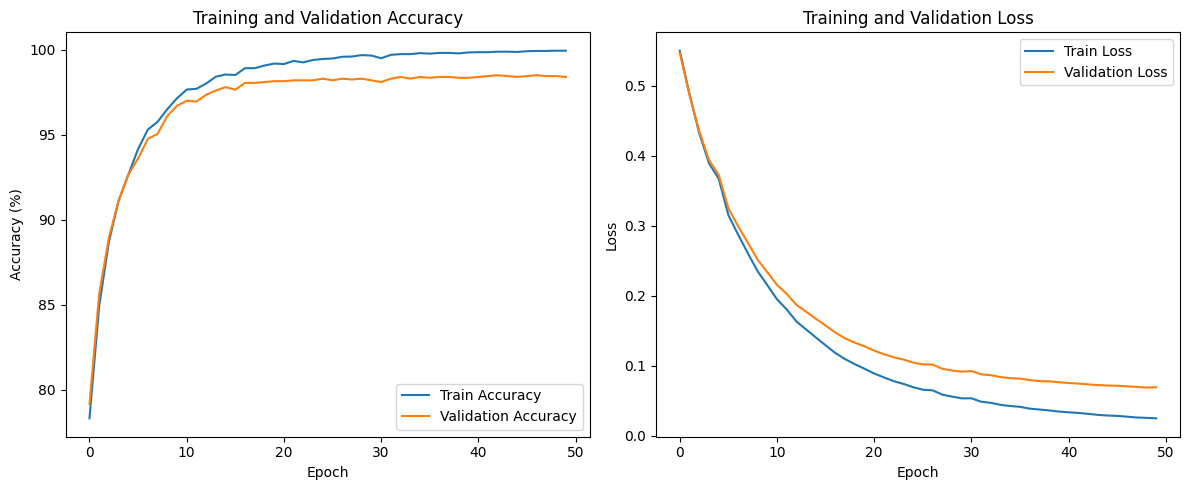

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()


def evaluate(dataloader, model, loss_fn):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    num_samples = len(dataloader.dataset)
    avg_accuracy = 100 * total_correct / num_samples
    avg_loss = total_loss / len(dataloader)
    return avg_accuracy, avg_loss


train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

epochs = 50
best_val_acc = 0
best_model = model

for epoch in range(epochs):
    train(train_loader, model, criterion, optimizer)
    train_acc, train_loss = evaluate(train_loader, model, criterion)
    val_acc, val_loss = evaluate(val_loader, model, criterion)

    # Store metrics
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.1f}%, Val Acc: {val_acc:.1f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()  # Save the best model

# After training, load the best model and evaluate on test data
model.load_state_dict(best_model)
test_acc, test_loss = evaluate(test_loader, model, criterion)
print(f"Final Validation Accuracy: {best_val_acc:.1f}%")
print(f"Test Accuracy: {test_acc:.1f}%, Test Loss: {test_loss:.4f}")

# Plotting the metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Load temperature data
T_test = np.loadtxt("T_L30.txt")

# Assuming T_test has the same order as the test dataset
# You should ensure that T_test is correctly aligned with your test dataset

# Prepare dataset with temperatures
print("x_test, y_test, T_test", x_test.shape, y_test.shape, T_test.shape)
test_dataset = TensorDataset(x_test, y_test, torch.tensor(T_test))

# Use DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)  # Batch size of 1 for individual predictions

model.eval()
accuracies = {}
outputs = {}

with torch.no_grad():
    for X, y, T in test_loader:
        pred = model(X)
        correct = (pred.argmax(1) == y).float()
        output_probs = torch.softmax(pred, dim=1).numpy()[0]

        temp = T.item()
        if temp not in accuracies:
            accuracies[temp] = []
            outputs[temp] = []
        accuracies[temp].append(correct.item())
        outputs[temp].append(output_probs)

# Calculate average accuracy and outputs for each temperature
avg_accuracy = {temp: np.mean(accuracies[temp]) for temp in accuracies}
avg_outputs = {temp: np.mean(outputs[temp], axis=0) for temp in outputs}

# Sorting the temperatures for plotting
sorted_temps = sorted(avg_accuracy.keys())

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(sorted_temps, [avg_accuracy[t] for t in sorted_temps], marker="o")
plt.title("Average Accuracy by Temperature")
plt.xlabel("Temperature")
plt.ylabel("Average Accuracy")

plt.subplot(1, 2, 2)
for i in range(2):  # Assuming two output neurons
    plt.plot(
        sorted_temps,
        [avg_outputs[t][i] for t in sorted_temps],
        label=f"Output Neuron {i+1}",
        marker="o",
    )
plt.title("Average Output from Neurons by Temperature")
plt.xlabel("Temperature")
plt.ylabel("Average Output")
plt.legend()

plt.tight_layout()
plt.show()

x_test, y_test, T_test torch.Size([1000, 30, 30]) torch.Size([1000]) (10000,)


AssertionError: Size mismatch between tensors

In [ ]:
# def evaluate(dataloader, model, loss_fn):
#     model.eval()
#     total_loss, total_correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             pred = model(X)
#             total_loss += loss_fn(pred, y).item()
#             total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     num_samples = len(dataloader.dataset)
#     avg_accuracy = 100 * total_correct / num_samples
#     avg_loss = total_loss / len(dataloader)
#     return avg_accuracy, avg_loss


# # After training and validation loop
# test_acc, test_loss = evaluate(test_loader, model, criterion)
# print(f"Test Accuracy: {test_acc:.1f}%, Test Loss: {test_loss:.4f}")

# print(f"Final Validation Accuracy: {val_acc:.1f}%")
# print(f"Test Accuracy: {test_acc:.1f}%")

# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
# criterion = nn.CrossEntropyLoss()

# epochs = 50
# best_val_acc = 0
# best_model = None

# for epoch in range(epochs):
#     train(train_loader, model, criterion, optimizer)
#     train_acc, train_loss = evaluate(train_loader, model, criterion)
#     val_acc, val_loss = evaluate(val_loader, model, criterion)

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_model = model.state_dict()  # Save the best model

#     print(f"Epoch {epoch+1}, Train Acc: {train_acc:.1f}%, Val Acc: {val_acc:.1f}%")

# # After training, load the best model and evaluate on test data
# model.load_state_dict(best_model)
# test_acc, test_loss = evaluate(test_loader, model, criterion)
# print(f"Final Validation Accuracy: {best_val_acc:.1f}%")
# print(f"Test Accuracy: {test_acc:.1f}%, Test Loss: {test_loss:.4f}")

In [ ]:
#             pred = model(X)
#             total_loss += loss_fn(pred, y).item()
#             total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     num_samples = len(dataloader.dataset)
#     avg_accuracy = 100 * total_correct / num_samples
#     avg_loss = total_loss / len(dataloader)
#     return avg_accuracy, avg_loss


# # After training and validation loop
# test_acc, test_loss = evaluate(test_loader, model, criterion)
# print(f"Test Accuracy: {test_acc:.1f}%, Test Loss: {test_loss:.4f}")

# print(f"Final Validation Accuracy: {val_acc:.1f}%")
# print(f"Test Accuracy: {test_acc:.1f}%")

# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
# criterion = nn.CrossEntropyLoss()

# epochs = 50
# best_val_acc = 0
# best_model = None

# for epoch in range(epochs):
#     train(train_loader, model, criterion, optimizer)
#     train_acc, train_loss = evaluate(train_loader, model, criterion)
#     val_acc, val_loss = evaluate(val_loader, model, criterion)

#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         best_model = model.state_dict()  # Save the best model

#     print(f"Epoch {epoch+1}, Train Acc: {train_acc:.1f}%, Val Acc: {val_acc:.1f}%")

# # After training, load the best model and evaluate on test data
# model.load_state_dict(best_model)
# test_acc, test_loss = evaluate(test_loader, model, criterion)
# print(f"Final Validation Accuracy: {best_val_acc:.1f}%")
# print(f"Test Accuracy: {test_acc:.1f}%, Test Loss: {test_loss:.4f}")

In [ ]:
# Old code:

# def plot_metrics(metrics, title="Model Performance"):
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     for label, data in metrics["accuracy"].items():
#         plt.plot(data, label=label)
#     plt.title("Accuracy vs. Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Accuracy")
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     for label, data in metrics["loss"].items():
#         plt.plot(data, label=label)
#     plt.title("Loss vs. Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()

#     plt.suptitle(title)
#     plt.show()


# weight_decays = [0, 0.001, 0.01, 0.1]
# metrics = {"accuracy": {}, "loss": {}}

# for decay in weight_decays:
#     model = IsingModelNN()  # Reinitialize model
#     optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=decay)
#     train_accuracies, val_accuracies = [], []
#     train_losses, val_losses = [], []

#     for epoch in range(epochs):
#         train(train_loader, model, criterion, optimizer)
#         train_acc, train_loss = validate(train_loader, model, criterion)
#         val_acc, val_loss = validate(val_loader, model, criterion)
#         train_accuracies.append(train_acc)
#         val_accuracies.append(val_acc)
#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#     metrics["accuracy"][f"wd={decay}"] = val_accuracies
#     metrics["loss"][f"wd={decay}"] = val_losses

# plot_metrics(metrics, "Impact of L2 Regularization")

In [ ]:
# # weight decay factor added; start with a small value
# weight_decay = 0.01
# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=weight_decay)
# # "SGD": optim.SGD(model.parameters(), lr=0.01),
# # "SGD with Momentum": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
# # "Adam": optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
# criterion = nn.CrossEntropyLoss()


# def train(dataloader, model, loss_fn, optimizer):
#     size = len(dataloader.dataset)
#     model.train()
#     for batch, (X, y) in enumerate(dataloader):
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


# def validate(dataloader, model, loss_fn):
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     model.eval()
#     loss, correct = 0, 0
#     with torch.no_grad():
#         for X, y in dataloader:
#             pred = model(X)
#             loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()
#     loss /= num_batches
#     correct /= size
#     return 100 * correct, loss


# epochs = 50
# for epoch in range(epochs):
#     train(train_loader, model, criterion, optimizer)
#     train_acc, train_loss = validate(train_loader, model, criterion)
#     val_acc, val_loss = validate(val_loader, model, criterion)
#     print(f"Epoch {epoch+1}, Train Acc: {train_acc:.1f}%, Val Acc: {val_acc:.1f}%")